In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in all the words.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [4]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}
vocabulary_size = len(itos)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 27


In [5]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

In [6]:
from typing import Any


class Linear():
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias      
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

class BatchNorm1d():
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wdith a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        if self.training:
            # check input's dimensionality
            if x.dim() == 2:
                dim = 0
            elif x.dim() == 3:
                dim = (0, 1)
            else:
                raise Exception(f'Able to process 2D or 3D tensors only, received {x.dim()}D tensor')
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1.0 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1.0 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding():
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX: torch.tensor) -> torch.tensor:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self) -> list[torch.tensor]:
        return [self.weight]
    

class FlattenConsecutive():
    def __init__(self, n: int) -> None:
        self.n = n  # number of consecutice elements

    def __call__(self, x: torch.tensor) -> torch.tensor:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return []
    

class Sequential():
    def __init__(self, layers: list) -> None:
        self.layers = layers
    
    def __call__(self, x: Any) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return [p for layer in self.layers for p in layer.parameters()]

In [81]:
torch.manual_seed(12)
a = torch.randn((3, 4), requires_grad=True)
b = torch.randn((2, 6), requires_grad=True)
c = torch.randn((5, 3), requires_grad=True)


abc = [a, b, c]
# manually summing regulization term to keep writing computational graph
loss = torch.tensor(0.0)
for p in abc:
    loss += p.square().sum()
loss.backward()

for i in abc:
    print(i.grad, end='\n\n')

tensor([[-0.4276, -2.7559, -0.1092,  0.9031],
        [ 1.5717, -2.1769, -1.1198, -1.8672],
        [ 0.0959, -0.1687, -0.2941,  1.5181]])

tensor([[ 0.2932, -2.0081, -1.5763, -1.6149, -0.5914, -0.2924],
        [ 0.7282,  0.8662,  1.1790, -2.5136,  0.8822, -0.5565]])

tensor([[-0.5175, -0.9448,  2.1115],
        [ 1.1367,  1.9326,  0.9655],
        [ 3.9146, -0.7319, -0.4532],
        [ 0.5610,  0.9189,  1.1718],
        [ 0.6932, -2.6904,  0.4942]])



In [38]:
torch.manual_seed(13);

In [83]:
# Split the dataset on train, development and test set.
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)


block_size = 8  # how many charecters do we take to predict the next one?
Xtrain, Ytrain = build_dataset(words[:n1], block_size, True)     # 80%
Xdevelop, Ydevelop = build_dataset(words[n1:n2], block_size, True) # 10%
Xtest, Ytest = build_dataset(words[n2:], block_size, True)     # 10%

Input: torch.Size([182597, 8]), Output: torch.Size([182597])
Input: torch.Size([22761, 8]), Output: torch.Size([22761])
Input: torch.Size([22788, 8]), Output: torch.Size([22788])


In [180]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str, evaluated_model: Sequential, lambda_: float = 0.0, use_reg: bool = False) -> None:
    """
    Given a split name, evaluates it and prints the result.
    Args:
        split(str): name of the dataset split you'd like to evaluate.
    """
    x, y = {  # Sets are global!
        'train': (Xtrain, Ytrain),
        'dev': (Xdevelop, Ydevelop),
        'test': (Xtest, Ytest)
    }[split]
    
    # swith to evaluation mode
    for layer in evaluated_model.layers:
        layer.training = False

    logits =  evaluated_model(x)
    loss = F.cross_entropy(logits, y)
    # regulization term - sum of squared parameters
    if use_reg:
        reg_term = torch.tensor(0.0)
        for param in evaluated_model.parameters():
            reg_term += param.square().sum()
        loss += lambda_ * reg_term
    
    # switch back to training mode
    for layer in evaluated_model.layers:
        layer.training = True
    
    return loss.item()

In [251]:
def train_model(
        n_embd: int, n_hidden: int, vocab_size: int,   # model's paramerers
        max_steps: int, batch_size: int, lr: float,    # training settings
        Xtr: torch.tensor, Ytr: torch.tensor,          # training and target sets
        lambda_: float = 0.0, use_reg: bool = False,   # regulization parameters
        custom_init: bool = False, hiddens: list = []  # switch to chaos mode)
) -> list:
    """
    Inintializes the models using given parameters and trains it with given settings on given sets.
    """
    if custom_init:
        model = Sequential([
            Embedding(vocab_size, n_embd), 
            FlattenConsecutive(2), Linear(n_embd * 2, hiddens[0], bias=False), BatchNorm1d(hiddens[0]), Tanh(),
            FlattenConsecutive(2), Linear(hiddens[0] * 2, hiddens[1], bias=False), BatchNorm1d(hiddens[1]), Tanh(),
            FlattenConsecutive(2), Linear(hiddens[1] * 2, hiddens[2], bias=False), BatchNorm1d(hiddens[2]), Tanh(),
            Linear(hiddens[2], vocab_size)
        ])
    else:
        model = Sequential([
            Embedding(vocab_size, n_embd), 
            FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, vocab_size)
        ])

    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # make last layer less confident
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True
    
    lossi = []
    trains = []
    develops = []
    for i in range(max_steps):
        """Mini-batch construct"""
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
        
        """Forward pass"""
        logits = model(Xb)
        # loss function
        loss = F.cross_entropy(logits, Yb)
        # regulization term - sum of squared parameters
        if use_reg:
            reg_term = torch.tensor(0.0)
            for param in parameters:
                reg_term += param.square().sum()
            loss += lambda_ * reg_term

        """Backward pass"""
        for p in parameters:
            p.grad = None
        loss.backward()
        
        """Update"""
        # if lr % 30000 == 0:
        #     lr *= 0.95   
        if i >= 150000:
            lr = 0.01
        if i >= 200000:
            lr = 0.001
        # lr = 1.0 if i < 90000 else 0.01  # learning step decay
        # if i % 20000 == 0:
        #     lr *= 0.97
        # if i > 150000:
        #     lr = 0.01
        #     # batch_size = 64
        for p in parameters:
            p.data += -lr * p.grad

        """Track stats"""
        if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
            train_loss = split_loss('train', model, 0.0, False)
            develop_loss = split_loss('dev', model, 0.0, False)
            trains.append(train_loss)
            develops.append(develop_loss)
        lossi.append(loss.log10().item())

    """Plotting"""
    # plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
    # train_loss = split_loss('train', model)
    # devlop_loss = split_loss('dev', model)
    return [trains, develops, lossi, model]

In [191]:
embedding_dim = 40
hidden_neurons = 100
learning_rate = 0.1 #0.257#0.5#0.7327
iterations = 100000
minibatch_size = 32
use_regulization = True
regulization_rate = 0.01

In [207]:
embedding_dim = 40
hidden_neurons = 100
learning_rate = 0.1 #0.257#0.5#0.7327
iterations = 100000
minibatch_size = 32
use_regulization = True
regulization_rate = 0.0005

trains, develops, losses = train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain,
    regulization_rate, 
    use_regulization
)

52407
      0/ 100000: 4.1403
  10000/ 100000: 2.1433
  20000/ 100000: 2.1772
  30000/ 100000: 1.6671
  40000/ 100000: 1.8881
  50000/ 100000: 2.2403
  60000/ 100000: 2.4150
  70000/ 100000: 1.7283
  80000/ 100000: 2.1212
  90000/ 100000: 2.4855


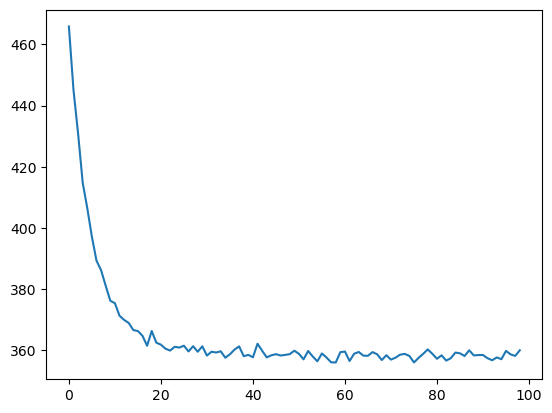

In [208]:
plt.plot(torch.tensor(losses[1000:]).view(-1, 1000).sum(1).tolist());

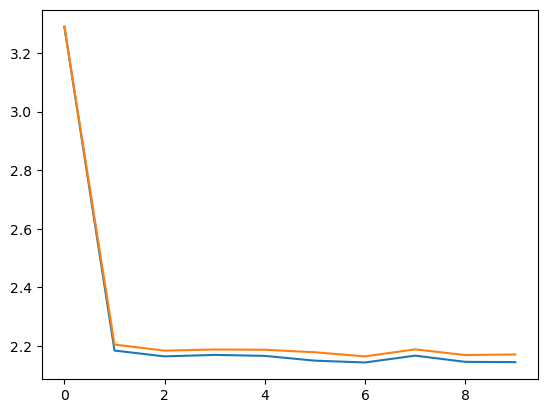

In [209]:
plt.plot(trains)
plt.plot(develops);

In [215]:
for lossesi in zip(trains, develops):
    print(lossesi[0], '|', lossesi[1])

3.2897608280181885 | 3.29057240486145
2.184615135192871 | 2.2050528526306152
2.1647446155548096 | 2.1843044757843018
2.1698060035705566 | 2.1882545948028564
2.1664912700653076 | 2.1872940063476562
2.150113344192505 | 2.178788661956787
2.143935203552246 | 2.1647894382476807
2.1672706604003906 | 2.1886653900146484
2.1461241245269775 | 2.169278860092163
2.1450562477111816 | 2.171182155609131


In [221]:
# This model seems pretty good to me. In 200k it's very likely to beat through 2.000 on dev set
# After 100k we are at | 1.978228211402893 | 2.0643062591552734 | with learning rate approximately
# equal to 0.1 * 0.95**3, which is 0.0857375
# The problem I see is that there's close to zero regulization happrning. I mean it's still here, but
# graphs become farther from each over during training (juat look at lambda_)
# And probably I overadded parameters, lets's look closely what's happening with the shapes
#                 (80)        (160)       (120)        (80)      (27)
# 120, 100, 80?  40 * 2 ---> 80 * 2 ---> 60 * 2 ---> 40 * 2 ---> 27
embedding_dim = 40  # 30?
hidden_neurons = 100  # doesn't change anything since chaos is on
learning_rate = 0.1 #0.257#0.5#0.7327
iterations = 100000
minibatch_size = 32
use_regulization = True
regulization_rate = 0.0001
enable_chaos = True
custom_hiddens = [200, 150, 100] 

trains, develops, losses = train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain,
    regulization_rate, 
    use_regulization,
    enable_chaos,
    custom_hiddens
)

110707
      0/ 100000: 3.4841
  10000/ 100000: 2.1971
  20000/ 100000: 2.4092
  30000/ 100000: 1.6498
  40000/ 100000: 2.2456
  50000/ 100000: 2.2004
  60000/ 100000: 2.5831
  70000/ 100000: 2.2401
  80000/ 100000: 2.1021
  90000/ 100000: 2.2089


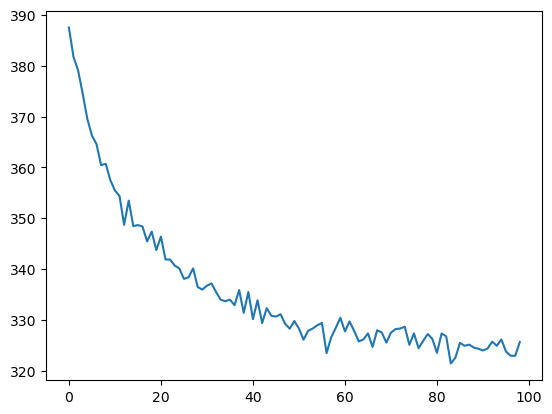

In [222]:
plt.plot(torch.tensor(losses[1000:]).view(-1, 1000).sum(1).tolist());

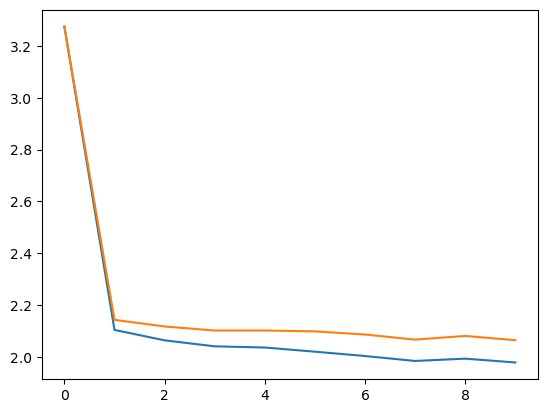

In [223]:
plt.plot(trains)
plt.plot(develops);

In [225]:
print(0.1 * 0.95**3)
for lossesi in zip(trains, develops):
    print(lossesi[0], '|', lossesi[1])

0.0857375
3.274557113647461 | 3.2752816677093506
2.103989601135254 | 2.142843246459961
2.063638925552368 | 2.1172125339508057
2.040562868118286 | 2.1015701293945312
2.035961151123047 | 2.1015968322753906
2.019920825958252 | 2.0983095169067383
2.0031561851501465 | 2.086168050765991
1.9840683937072754 | 2.0665090084075928
1.9930037260055542 | 2.0806679725646973
1.978228211402893 | 2.0643062591552734


In [227]:
# Exactly as above but fully optimized with lr cutted down to 0.01 after 150k
embedding_dim = 40  # 30?
hidden_neurons = 100  # doesn't change anything since chaos is on
learning_rate = 0.1 #0.257#0.5#0.7327
iterations = 200000
minibatch_size = 32
use_regulization = True
regulization_rate = 0.0001
enable_chaos = True
custom_hiddens = [200, 150, 100]  # 120, 100, 80?  40 * 2 ---> 200 * 2 ---> 150 * 2 ---> 200 * 2 ---> 27

trains, develops, losses = train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain,
    regulization_rate, 
    use_regulization,
    enable_chaos,
    custom_hiddens
)

110707
      0/ 200000: 3.4909
  10000/ 200000: 2.4406
  20000/ 200000: 2.0679
  30000/ 200000: 2.2796
  40000/ 200000: 2.1093
  50000/ 200000: 2.2877
  60000/ 200000: 2.1260
  70000/ 200000: 1.7720
  80000/ 200000: 2.3094
  90000/ 200000: 2.3432
 100000/ 200000: 2.0599
 110000/ 200000: 2.0512
 120000/ 200000: 2.0282
 130000/ 200000: 2.1099
 140000/ 200000: 2.1127
 150000/ 200000: 2.2880
 160000/ 200000: 2.0525
 170000/ 200000: 1.7951
 180000/ 200000: 2.0502
 190000/ 200000: 1.7699


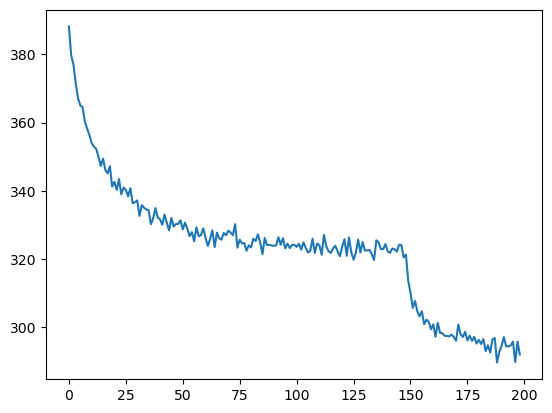

In [228]:
plt.plot(torch.tensor(losses[1000:]).view(-1, 1000).sum(1).tolist());

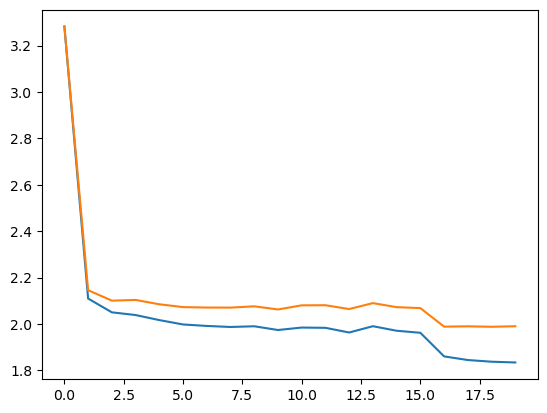

In [230]:
plt.plot(trains)
plt.plot(develops);

In [229]:
# Good, we won, not really much, around 0.004 haha and it costed us somewhere about 34k parameters)))
# Maybe it's all random initialization, I don't know, but I'll stay here for aa litte bit longer.
# Now it's time for a lunch, but after I'm done with it I'd like to test some ideas I have.
print(0.1 * 0.95**3)
for lossesi in zip(trains, develops):
    print(lossesi[0], '|', lossesi[1])

0.0857375
3.2825186252593994 | 3.2827467918395996
2.109278678894043 | 2.1452856063842773
2.0498669147491455 | 2.100238084793091
2.03818416595459 | 2.103315830230713
2.0163466930389404 | 2.084534168243408
1.9975422620773315 | 2.0724010467529297
1.9911421537399292 | 2.070481777191162
1.9866533279418945 | 2.0702056884765625
1.989706039428711 | 2.0757315158843994
1.973616600036621 | 2.062265634536743
1.9842019081115723 | 2.080016851425171
1.9830316305160522 | 2.080451726913452
1.9628996849060059 | 2.0639946460723877
1.9900137186050415 | 2.0896458625793457
1.970408320426941 | 2.072127342224121
1.961614966392517 | 2.068070650100708
1.8598212003707886 | 1.9881036281585693
1.8440937995910645 | 1.9894890785217285
1.8368966579437256 | 1.987518548965454
1.833574891090393 | 1.98994779586792


In [241]:
# 2.022 on full optimization!
#                 (120)        (240)       (120)       (60)      (27)
# 120, 100, 80?  60 * 2 ---> 120 * 2 ---> 60 * 2 ---> 30 * 2 ---> 27
# maybe thes scheme hasn't that much parameters, but at least it seems to me
# scaling parameters relatively not that much compared to representation dimensionality
embedding_dim = 60  # 30?
hidden_neurons = 100  # doesn't change anything since chaos is on
learning_rate = 0.1 #0.257#0.5#0.7327
iterations = 200000
minibatch_size = 32
use_regulization = False
regulization_rate = 0.0001
enable_chaos = True
custom_hiddens = [120, 60, 30] 

trains, develops, losses = train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain,
    regulization_rate, 
    use_regulization,
    enable_chaos,
    custom_hiddens
)

35277
      0/ 200000: 3.3058
  10000/ 200000: 2.4792
  20000/ 200000: 2.1171
  30000/ 200000: 1.8624
  40000/ 200000: 2.5500
  50000/ 200000: 2.0565
  60000/ 200000: 2.1466
  70000/ 200000: 1.6866
  80000/ 200000: 1.9650
  90000/ 200000: 2.1949
 100000/ 200000: 2.1170
 110000/ 200000: 1.8717
 120000/ 200000: 2.0133
 130000/ 200000: 2.1587
 140000/ 200000: 1.8519
 150000/ 200000: 1.6850
 160000/ 200000: 2.0980
 170000/ 200000: 1.9493
 180000/ 200000: 2.1505
 190000/ 200000: 2.1861


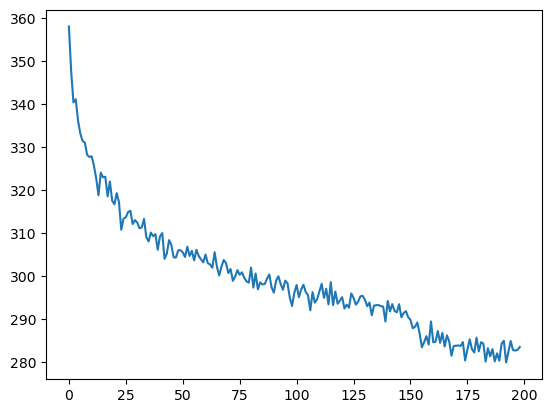

In [242]:
plt.plot(torch.tensor(losses[1000:]).view(-1, 1000).sum(1).tolist());

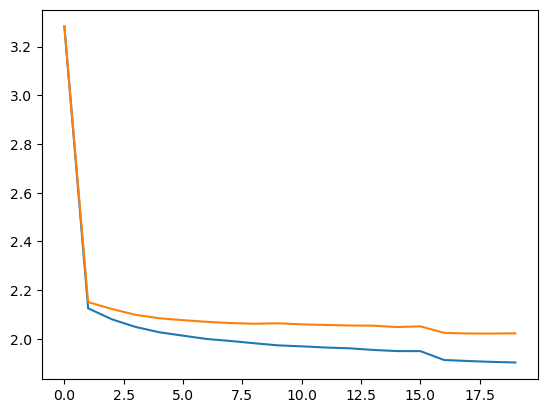

In [243]:
plt.plot(trains)
plt.plot(develops);

In [244]:
print(0.1 * 0.95**3)
for lossesi in zip(trains, develops):
    print(lossesi[0], '|', lossesi[1])

0.0857375
3.2829296588897705 | 3.282794952392578
2.125136375427246 | 2.1506834030151367
2.0801870822906494 | 2.122622013092041
2.0486600399017334 | 2.0983684062957764
2.0267391204833984 | 2.0843403339385986
2.012876510620117 | 2.0765295028686523
1.9991884231567383 | 2.069807529449463
1.9909639358520508 | 2.0646722316741943
1.9817296266555786 | 2.061876058578491
1.973005771636963 | 2.0637385845184326
1.9689524173736572 | 2.0593230724334717
1.9642517566680908 | 2.056851387023926
1.9609707593917847 | 2.054733991622925
1.954329252243042 | 2.0538907051086426
1.9495741128921509 | 2.0483100414276123
1.949325680732727 | 2.0511350631713867
1.9128168821334839 | 2.024397373199463
1.9087936878204346 | 2.021744966506958
1.905189037322998 | 2.0215983390808105
1.9027187824249268 | 2.0223228931427


In [264]:
# Version above has 35k parameters only and you know what, I believe in it.
# 2.06 dev loss after 100k only without lr crushing.
#                 (200)        (400)       (200)       (100)      (27)
# 120, 100, 80?  100 * 2 ---> 200 * 2 ---> 100 * 2 ---> 50 * 2 ---> 27
# maybe thes scheme hasn't that much parameters, but at least it seems to me
# scaling parameters relatively not that much compared to representation dimensionality
embedding_dim = 80  # 30?
hidden_neurons = 100  # doesn't change anything since chaos is on
learning_rate = 0.1 #0.257#0.5#0.7327
iterations = 250000
minibatch_size = 32
use_regulization = True # why regulizing alpha and beta too. Excluding them is worth trying.
regulization_rate = 0.00025
enable_chaos = True
custom_hiddens = [200, 100, 50] 

trains, develops, losses, trained_model = train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain,
    regulization_rate, 
    use_regulization,
    enable_chaos,
    custom_hiddens
)

86237
      0/ 250000: 4.0221
  10000/ 250000: 2.5231
  20000/ 250000: 2.2934
  30000/ 250000: 2.0012
  40000/ 250000: 2.4757
  50000/ 250000: 2.1289
  60000/ 250000: 2.3145
  70000/ 250000: 2.1711
  80000/ 250000: 2.4370
  90000/ 250000: 2.3354
 100000/ 250000: 2.3009
 110000/ 250000: 2.4492
 120000/ 250000: 1.8703
 130000/ 250000: 2.0581
 140000/ 250000: 2.0222
 150000/ 250000: 2.2460
 160000/ 250000: 2.5337
 170000/ 250000: 1.9967
 180000/ 250000: 2.0942
 190000/ 250000: 1.9749
 200000/ 250000: 1.9239
 210000/ 250000: 2.2803
 220000/ 250000: 1.9890
 230000/ 250000: 1.9474
 240000/ 250000: 1.8897


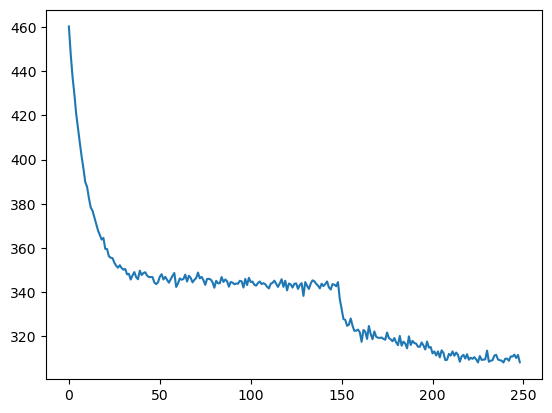

In [265]:
plt.plot(torch.tensor(losses[1000:]).view(-1, 1000).sum(1).tolist());

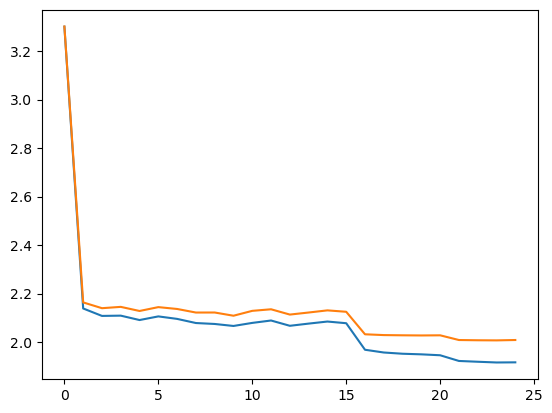

In [266]:
plt.plot(trains)
plt.plot(develops);

In [267]:
# ok that's enough for me. I feel like I got something from the exercise.
# I think I played enough and tried more, than Andrew did.
# I found a scalable architcture and learning parameters for it so as
# more of steps and parameters decrease the loss, even if not that much.
print(0.1 * 0.95**3)
for lossesi in zip(trains, develops):
    print(lossesi[0], '|', lossesi[1])

0.0857375
3.301065683364868 | 3.3018925189971924
2.138425827026367 | 2.163422107696533
2.1077067852020264 | 2.1395890712738037
2.1088438034057617 | 2.145038604736328
2.0906946659088135 | 2.1280815601348877
2.1057112216949463 | 2.14398455619812
2.0954349040985107 | 2.1363606452941895
2.0783565044403076 | 2.1216325759887695
2.074486017227173 | 2.1217634677886963
2.0662572383880615 | 2.108485698699951
2.078885555267334 | 2.1286163330078125
2.088775396347046 | 2.135089159011841
2.0669548511505127 | 2.113248109817505
2.0759987831115723 | 2.1217386722564697
2.08449387550354 | 2.1306002140045166
2.0775933265686035 | 2.1247711181640625
1.9680849313735962 | 2.0319013595581055
1.956758975982666 | 2.028632640838623
1.9516570568084717 | 2.027719497680664
1.9491537809371948 | 2.0271031856536865
1.9453843832015991 | 2.0276706218719482
1.9218677282333374 | 2.008253335952759
1.918613076210022 | 2.0072386264801025
1.9156073331832886 | 2.006761312484741
1.9161678552627563 | 2.008301019668579


In [12]:
# learning rate = 0.7327, 0.25
trains, develops = [], []
lrs = torch.linspace(1.0, 0.01, 5).tolist()
for i in range(len(lrs)):
    learning_rate = lrs[i]
    trains, develops, losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(trains[-1])
    develops.append(develops[-1])

    print('-'*40)
    print(f'{learning_rate = }')
    print(' Train | Develop')
    print(trains[-1], develops[-1])
    print('-'*40)

plt.plot(lrs, trains)
plt.plot(lrs, develops)

50137
      0/ 200000: 3.2962


KeyboardInterrupt: 

In [34]:
torch.set_num_threads(32)

In [ ]:
# Bigger size is better, 256 seemed best on 8 context length
trains, develops = [], []
batch_sizes = [256, 512]
for i in range(len(batch_sizes)):
    minibatch_size = batch_sizes[i]
    losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(losses[0])
    develops.append(losses[1])

    print('-'*40)
    print(f'{minibatch_size = }')
    print(' Train | Develop')
    print(losses)
    print('-'*40)

plt.plot(batch_sizes, trains)
plt.plot(batch_sizes, develops)

In [119]:
# 20 is good
trains, develops = [], []
embdims = [4, 8, 12, 16, 20, 24, 28]
for i in range(len(embdims)):
    embedding_dim = embdims[i]
    trs, devs, losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(trs[-1])
    develops.append(devs[-1])

    print('-'*40)
    print(f'{embedding_dim = }')
    print(' Train | Develop')
    print(trs[-1], devs[-1])
    print('-'*40)

plt.plot(embdims, [tr.item() for tr in trains])
plt.plot(embdims, [dev.item() for dev in develops])

22605
      0/  10000: 3.2955
   1000/  10000: 2.4760
   2000/  10000: 2.3594
   3000/  10000: 2.1840
   4000/  10000: 2.2305
   5000/  10000: 2.5931
   6000/  10000: 2.0510
   7000/  10000: 2.3236
   8000/  10000: 1.8810
   9000/  10000: 2.1109
----------------------------------------
embedding_dim = 4
 Train | Develop
2.15006160736084 2.1831321716308594
----------------------------------------
23273
      0/  10000: 3.2955
   1000/  10000: 2.1431
   2000/  10000: 2.3586
   3000/  10000: 2.1735
   4000/  10000: 2.0052
   5000/  10000: 2.3233
   6000/  10000: 2.3741
   7000/  10000: 2.0575
   8000/  10000: 2.1175
   9000/  10000: 2.0643
----------------------------------------
embedding_dim = 8
 Train | Develop
2.115809202194214 2.16291880607605
----------------------------------------
23941
      0/  10000: 3.2950
   1000/  10000: 2.3502
   2000/  10000: 2.2028
   3000/  10000: 2.3089
   4000/  10000: 2.2177
   5000/  10000: 2.2565
   6000/  10000: 2.1711
   7000/  10000: 2.3632
   80

AttributeError: 'float' object has no attribute 'item'

9887
      0/  10000: 3.2957
   1000/  10000: 2.3895
   2000/  10000: 2.1604
   3000/  10000: 2.3616
   4000/  10000: 1.9456
   5000/  10000: 2.0524
   6000/  10000: 2.2385
   7000/  10000: 2.1490
   8000/  10000: 2.1307
   9000/  10000: 2.1992
----------------------------------------
hidden_neurons = 40
 Train | Develop
2.127599000930786 2.15541410446167
----------------------------------------
14217
      0/  10000: 3.2957
   1000/  10000: 2.2374
   2000/  10000: 2.2025
   3000/  10000: 2.4768
   4000/  10000: 2.1942
   5000/  10000: 2.0518
   6000/  10000: 2.0729
   7000/  10000: 2.1808
   8000/  10000: 1.8511
   9000/  10000: 2.3014
----------------------------------------
hidden_neurons = 50
 Train | Develop
2.1007065773010254 2.1337342262268066
----------------------------------------
19347
      0/  10000: 3.2955
   1000/  10000: 2.3586
   2000/  10000: 2.3541
   3000/  10000: 2.1339
   4000/  10000: 2.3487
   5000/  10000: 2.1437
   6000/  10000: 2.0633
   7000/  10000: 2.0565


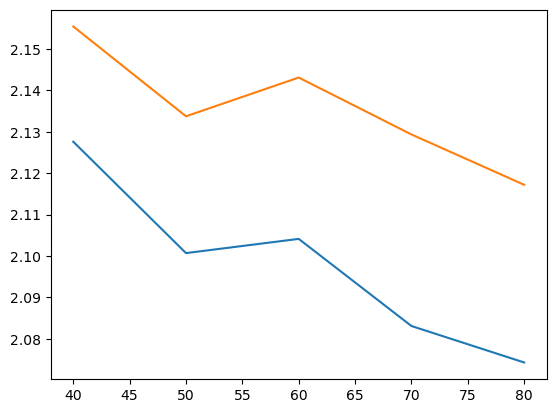

In [123]:
# 70 is good
trains, develops = [], []
neurons_amounts = [40, 50, 60, 70, 80]
for i in range(len(neurons_amounts)):
    hidden_neurons = neurons_amounts[i]
    trs, devs, losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(trs[-1])
    develops.append(devs[-1])

    print('-'*40)
    print(f'{hidden_neurons = }')
    print(' Train | Develop')
    print(trs[-1], devs[-1])
    print('-'*40)

plt.plot(neurons_amounts, trains)
plt.plot(neurons_amounts, develops)

In [51]:
trains, develops, losses= train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain
)

losses = torch.tensor(losses).view(-1, 1000).sum(1).tolist()

72267
      0/ 200000: 3.2937
  10000/ 200000: 1.9888
  20000/ 200000: 2.2617
  30000/ 200000: 1.8993
  40000/ 200000: 2.1750
  50000/ 200000: 2.0102
  60000/ 200000: 2.1025
  70000/ 200000: 1.7214
  80000/ 200000: 1.6774
  90000/ 200000: 1.7541
 100000/ 200000: 1.9380
 110000/ 200000: 1.4028
 120000/ 200000: 1.4980
 130000/ 200000: 2.0226
 140000/ 200000: 2.0066
 150000/ 200000: 1.6397
 160000/ 200000: 2.0559
 170000/ 200000: 1.7135
 180000/ 200000: 1.8001
 190000/ 200000: 1.2147


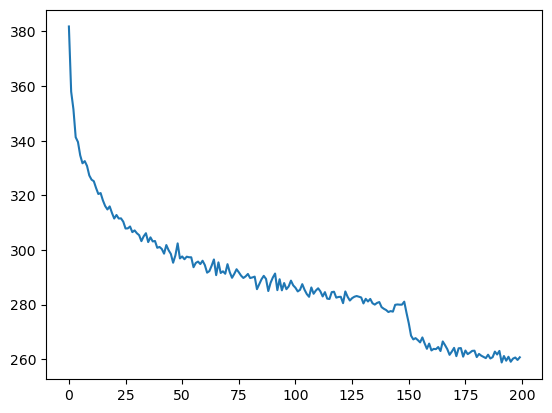

In [52]:
plt.plot(losses);

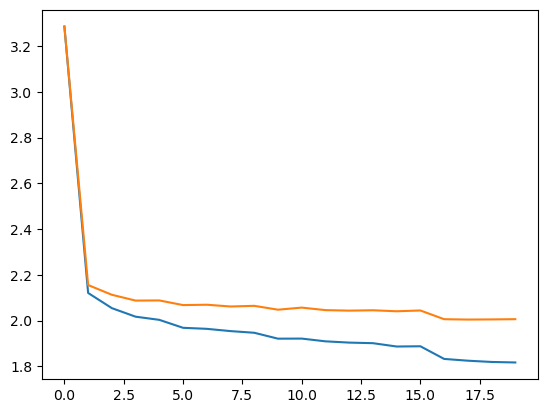

In [53]:
plt.plot(trains)
plt.plot(develops);

In [ ]:
""" Sampling from model
# Sample from the model.
g = torch.Generator().manual_seed(13 + 10)
for _ in range (20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context])) # (1, block_size, n_embd)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '' token, break
        if ix == 0:
            break
    print("".join(itos[i] for i in out)) # decode and print the generated word
"""

In [55]:
trains[-1], develops[-1]

(1.8165212869644165, 2.0059585571289062)

In [56]:
develops

[3.286442279815674,
 2.155273675918579,
 2.1126976013183594,
 2.0872652530670166,
 2.087939500808716,
 2.0675771236419678,
 2.06917142868042,
 2.0614511966705322,
 2.0643179416656494,
 2.0474259853363037,
 2.0565781593322754,
 2.0455830097198486,
 2.0433194637298584,
 2.044924259185791,
 2.0405561923980713,
 2.0440115928649902,
 2.0058629512786865,
 2.0042388439178467,
 2.004897117614746,
 2.0059585571289062]

In [1]:
trains

NameError: name 'trains' is not defined